In [1]:
BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 5
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 400
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.util import montage as montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = '../input'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')
import gc; gc.enable() # memory is tight

TO convert the images into the runlength encoding or to decode them back.Also to mask the image based on the value of runlength encoding.
Reference :-: https://www.kaggle.com/paulorzp/run-length-encode-and-decode

In [3]:
from skimage.morphology import label
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]


def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
   # print(starts)
    ends = starts + lengths
    #print(ends)
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [4]:
masks = pd.read_csv(os.path.join('../input',
                                 'train_ship_segmentations_v2.csv'))
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks.head()

231723 masks found
192556


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


,ImageId,ships,has_ship,has_ship_vec,file_size_kb
142959,be12550f4.jpg,0,0.0,[0.0],168.923828
17953,17db1b3a9.jpg,0,0.0,[0.0],103.409180
62863,53be9c6db.jpg,0,0.0,[0.0],193.915039
27748,24e73aeac.jpg,0,0.0,[0.0],99.054688
83318,6eaab8529.jpg,0,0.0,[0.0],129.140625


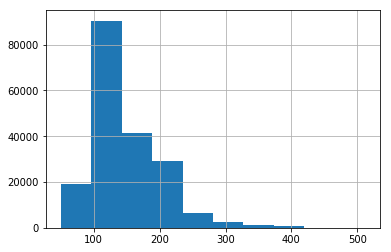

In [5]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# calculate the size of the images as some files are too small/corrupt we need to ignore them
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(train_image_dir, 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>50] # keep only 50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(5)

In [ ]:
len(masks)

In [ ]:
%%time

from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.3, 
                 stratify = unique_img_ids['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

In [ ]:
train_df.shape[0]

In [ ]:
train_df['grouped_ship_count'] = train_df['ships'].map(lambda x: (x+1)//2).clip(0, 7)
# 1500*7(for the images) + 500 for the non images
def sample_ships(in_df, base_rep_val=1500):
    if in_df['ships'].values[0]==0:
        return in_df.sample(base_rep_val//3) # even more strongly undersample no ships
    else:
        return in_df.sample(base_rep_val, replace=(in_df.shape[0]<base_rep_val))
    
balanced_train_df = train_df.groupby('grouped_ship_count').apply(sample_ships)
balanced_train_df['ships'].hist(bins=np.arange(10))

In [ ]:
len(balanced_train_df)

In [ ]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

In [ ]:
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 15, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

In [ ]:
def conv_block(filters,  strides=(2, 2)):
    
    def layer(input_tensor):
        x = BatchNormalization()(input_tensor)
        x = Activation('relu')(x)
        shortcut = x
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), strides=strides)(x)

        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3))(x)

        shortcut = Conv2D(filters, (1, 1), strides=strides)(shortcut)
        x = Add()([x, shortcut])
        return x
    return layer


def identity_block(filters):

    def layer(input_tensor):
        x = BatchNormalization()(input_tensor)
        x = Activation('relu')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3))(x)

        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3))(x)

        x = Add()([x, input_tensor])
        return x

    return layer

In [ ]:
def up_block(filters, kernel_size=(3,3), upsample_rate=(2,2),
                     batchnorm=False, skip=None):

    def layer(input_tensor):

        x = UpSampling2D(size=upsample_rate)(input_tensor)

        if skip is not None:
            x = Concatenate()([x, skip])

        x = Conv2D(filters, kernel_size, padding='same')(x)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(filters, kernel_size, padding='same')(x)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Activation('relu')(x)

        return x
    return layer


In [ ]:
import keras.backend as K
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import GlobalAveragePooling2D
from keras.layers import ZeroPadding2D
from keras.layers import Dense
from keras.models import Model
from keras.engine import get_source_inputs
from keras.layers import Add
from keras.layers import UpSampling2D
from keras.layers import Concatenate

In [ ]:
def UResNet34(input_shape=(None, None, 3), classes=1, decoder_filters=16,  include_top=True, input_tensor=None):
    from keras_applications.imagenet_utils import _obtain_input_shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=197,
                                      data_format='channels_last',
                                      require_flatten=include_top)
    if input_tensor is None:
        img_input = Input(shape=input_shape, name='data')
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
            
    # resnet bottom
    x = BatchNormalization()(img_input)
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv0')(x)
    x = BatchNormalization(name='bn0')(x)
    x = Activation('relu', name='relu0')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pooling0')(x)
    
    #resent model 
    x = conv_block(64,strides=(1, 1))(x)
    x = identity_block(64)(x)
    
    x = conv_block(128, strides=(2, 2))(x)
    x = identity_block(128)(x)
    
    x = conv_block(128, strides=(2, 2))(x)
    x = identity_block(128)(x)
    
    x = conv_block(256, strides=(2, 2))(x)
    x = identity_block(256)(x)
    
    x = conv_block(256, strides=(2, 2))(x)
    x = identity_block(256)(x)
    
    x = conv_block(512, strides=(2, 2))(x)
    x = identity_block(512)(x)
    
    x = conv_block(512, strides=(2, 2))(x)
    x = identity_block(512)(x)
    
    x = BatchNormalization()(x)
    x = Activation('relu', name='relu1')(x)
    

    backbone = Model(img_input, x)
    backbone.layers
    #unet model
    #skip = None
    skip = backbone.layers[120].output
    x = up_block(256, upsample_rate=(2,2), skip=skip)(x)
    skip = None
    x = up_block(128, upsample_rate=(2,2), skip=skip)(x)
    skip = backbone.layers[68].output
    x = up_block(128, upsample_rate=(2,2), skip=skip)(x)
    skip = None
    x = up_block(64, upsample_rate=(2,2), skip=skip)(x)
    skip = backbone.layers[30].output
    x = up_block(64, upsample_rate=(2,2), skip=skip)(x)
    skip = None
    x = up_block(32, upsample_rate=(2,2), skip=skip)(x)
    skip = backbone.layers[4].output
    x = up_block(32, upsample_rate=(2,2), skip=skip)(x)
    skip = None
    x = up_block(16, upsample_rate=(2,2), skip=skip)(x)
    x = Conv2D(1, (3,3), padding='same', name='final_conv')(x)

    activation = 'sigmoid'
    x = Activation(activation, name=activation)(x)
    model = Model(img_input, x)
    return model




In [ ]:
seg_model = UResNet34(input_shape=(768,768,3))

In [ ]:
len(seg_model.layers)

In [ ]:
seg_model.summary()

In [ ]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy



In [ ]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

In [ ]:
def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))


In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)


In [ ]:
def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)


In [ ]:
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=bce_logdice_loss, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [ ]:
%%time

epochs = 100
batch_size = 32

step_count = min(MAX_TRAIN_STEPS, balanced_train_df.shape[0]//BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen(balanced_train_df))
loss_history = [seg_model.fit_generator(aug_gen,
                            steps_per_epoch=step_count,
                            validation_data=(valid_x, valid_y), 
                            epochs=10,
                            callbacks=callbacks_list,shuffle=True)]

In [ ]:
seg_model.load_weights(weight_path)
seg_model.save('seg_model.h5')

In [ ]:
test_paths = os.listdir(test_image_dir)
print(len(test_paths), 'test images found')

In [ ]:
fig, m_axs = plt.subplots(20, 2, figsize = (10, 40))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2), c_img_name in zip(m_axs, test_paths):
    c_path = os.path.join(test_image_dir, c_img_name)
    c_img = imread(c_path)
    first_img = np.expand_dims(c_img, 0)/255.0
    first_seg = seg_model.predict(first_img)
    ax1.imshow(first_img[0])
    ax1.set_title('Image')
    ax2.imshow(first_seg[0,:, :, 0])
    ax2.set_title('Prediction')
fig.savefig('test_predictions.png')